In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

starting of paralle.py
paralle.py/parallel is printing


In [2]:
df=pd.read_parquet('tezcatli_orders_data.parquet')

In [17]:
# top 3
# C+ St Plk         689915
# C+ St NT3         425402
# Pr Plk            403583

# region top
# Midwest East              124271
# Carolinas                 105971

In [3]:
def preprocess_data(df,region,forecast):
    df=df[df['Product Segment'].isin(['Exterior','Interior'])]
    df=df[df['Region Name']!='Export/Interco']
    df=df[df['Region Name']==region]
    df=df[df['forecast_group']==forecast]
    df=df[['Order Create Date','Order Volume (STD)']]
    df['Order Create Date']=pd.to_datetime(df['Order Create Date'])
    df=df.sort_values(by='Order Create Date')
    df=df.reset_index(drop=True)
    df['year'] = df['Order Create Date'].dt.year
    df['month'] = df['Order Create Date'].dt.month
    df = df.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()
    df['date']=df['year'].astype('string')+'-'+df['month'].astype('string')+'-01'
    df.set_index('date',inplace=True)
    df=df.drop(['year','month'],axis=1)
    df.index=pd.to_datetime(df.index)
    return df
# check stationary test dickey fuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [4]:
df=preprocess_data(df,'Carolinas','Pr Plk')

In [5]:
adf_test(df['Order Volume (STD)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.127595
p-value                   0.946620
# lags used              13.000000
# observations          110.000000
critical value (1%)      -3.491245
critical value (5%)      -2.888195
critical value (10%)     -2.580988
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [6]:
adf_test(df['Order Volume (STD)'].diff(1).dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.940912
p-value                   0.040793
# lags used              12.000000
# observations          110.000000
critical value (1%)      -3.491245
critical value (5%)      -2.888195
critical value (10%)     -2.580988
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [13]:
# data has seasonality and it is yearly seasonal

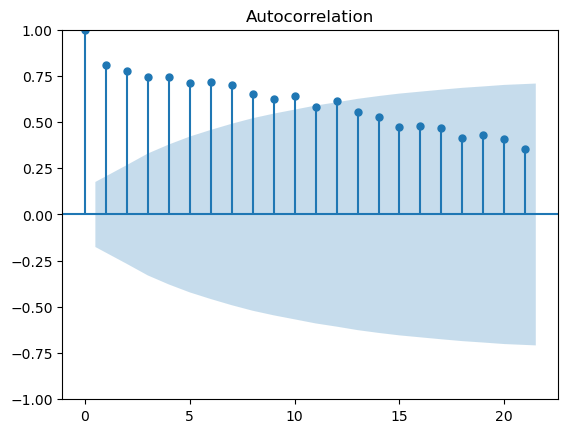

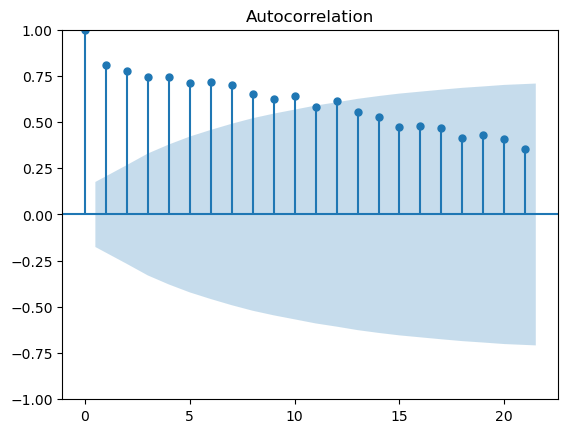

In [7]:
plot_acf(df)

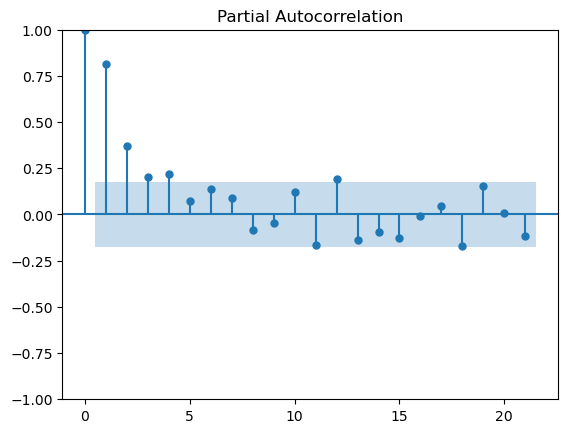

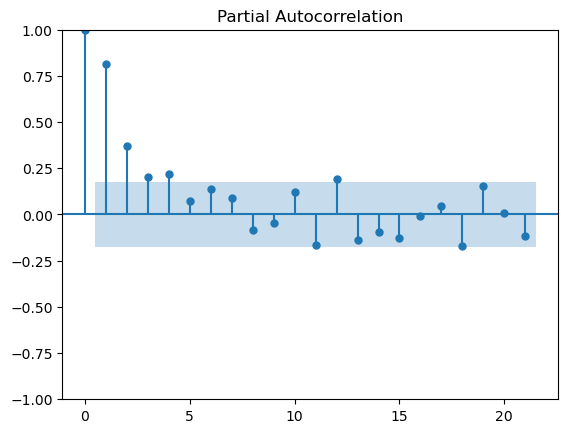

In [8]:
plot_pacf(df)

In [10]:
def allinOne_val(df,p,d,q):
    # df.plot()
    sd=seasonal_decompose(df['Order Volume (STD)'])
    sd.plot();
    auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=12).summary()
    print('auto_arima_result',auto_arima_result)
    train=df[:'2021-12-01']
    val=df['2022-01-01':'2022-10-01']
    test=df['2022-11-01':]
    start=len(train)
    end=len(train) + len(val)-1
    model=SARIMAX(train['Order Volume (STD)'],order=(p, d, q))
    results=model.fit()
    predictions_val=results.predict(start,end).rename('SARIMAX  predict')
    val['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(val['Order Volume (STD)'],predictions_val)*100)

auto_arima_result                                      SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  124
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1832.110
Date:                            Tue, 29 Aug 2023   AIC                           3672.221
Time:                                    10:40:21   BIC                           3683.470
Sample:                                04-01-2013   HQIC                          3676.790
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7224      0.062    -11.559      0.000      -0.845      -0.600
ar.S.L12       0.

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


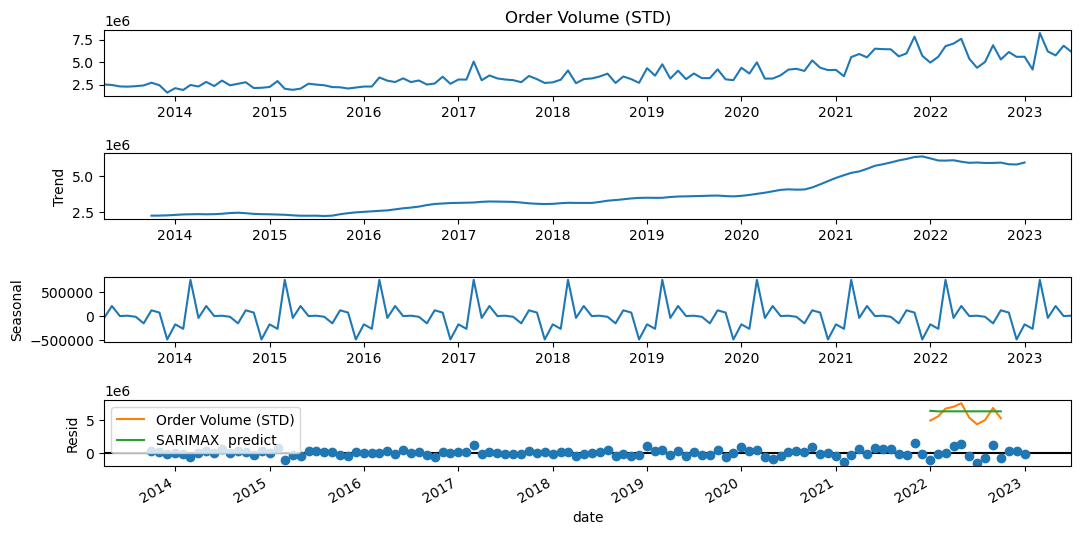

mean_absolute_percentage_error_val 19.420544923083398


In [11]:
allinOne_val(df,1,1,1)

In [46]:
train_1=train.iloc[-15:]

<AxesSubplot:>

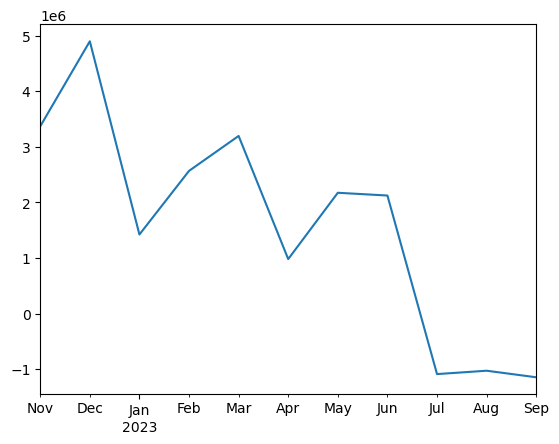

In [93]:

predictions.plot()

<AxesSubplot:>

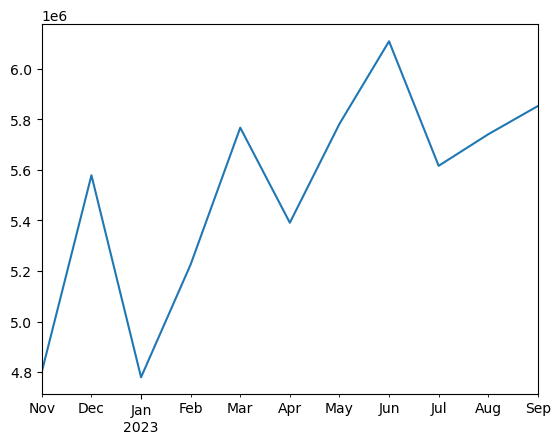

In [55]:
# train_1.plot()
predictions.plot()

In [49]:
predictions

2022-11-01    4.802383e+06
2022-12-01    5.578865e+06
2023-01-01    4.779883e+06
2023-02-01    5.225991e+06
2023-03-01    5.767078e+06
2023-04-01    5.391073e+06
Freq: MS, Name: SARIMAX  predict, dtype: float64

In [12]:
# test=df['2022-11-01':]
start=len(train_1)
end=len(train_1) + 10
model=SARIMAX(train_1['Order Volume (STD)'],order=(0, 1, 1),seasonal_order=(1,0,1,12))
results=model.fit()
predictions=results.predict(start,end).rename('SARIMAX  predict')

NameError: name 'train_1' is not defined

In [ ]:
order=(0, 1, 1),seasonal_order=(1,0,1,12))

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46935D+01    |proj g|=  4.09628D-02

At iterate    5    f=  1.46846D+01    |proj g|=  1.78207D-02

At iterate   10    f=  1.46826D+01    |proj g|=  1.86694D-03

At iterate   15    f=  1.46823D+01    |proj g|=  2.10617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   1.031D-05   1.468D+01
  F =   14.682285566060148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


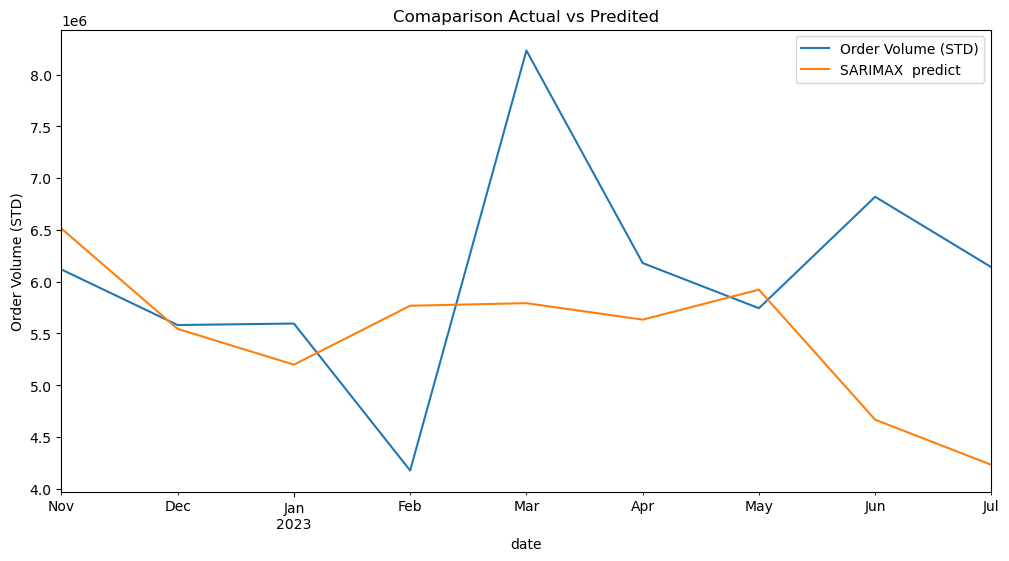

mean_absolute_percentage_error_val 17.39717054434366


In [14]:
train=df[:'2022-10-01']
# val=df[:'2022-10-01']
test=df['2022-11-01':]
start=len(train)
end=len(train) + len(test)-1
model=SARIMAX(train['Order Volume (STD)'],order=(1, 1, 1),seasonal_order=(1,0,1,12))
model.initialize_approximate_diffuse()
results=model.fit()
predictions=results.predict(start,end).rename('SARIMAX  predict')
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions.plot(legend=True)
plt.ylabel('Order Volume (STD)')
plt.title('Comaparison Actual vs Predited')
plt.show()
print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)*100)

In [15]:
pd.DataFrame(predictions)

,SARIMAX predict
2022-11-01,6.513392e+06
2022-12-01,5.544296e+06
2023-01-01,5.199048e+06
2023-02-01,5.767895e+06
2023-03-01,5.792801e+06
2023-04-01,5.633709e+06
2023-05-01,5.923001e+06
2023-06-01,4.667207e+06
2023-07-01,4.231430e+06


In [16]:
test

,Order Volume (STD)
date,
2022-11-01,6118239.5
2022-12-01,5581463.5
2023-01-01,5596008.5
2023-02-01,4176359.5
2023-03-01,8232933.5
2023-04-01,6180111.0
2023-05-01,5743970.0
2023-06-01,6820291.5
2023-07-01,6139854.0


### Final 

In [49]:
# model2=SARIMAX(train['Order Volume (STD)'],order=(10, 1, 10))
# results2=model2.fit()
# predictions2=results2.predict(start,end).rename('SARIMAX  predict')
# test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,label='Order Volume (STD) Actual')
# predictions2.plot(legend=True)
# # plt.xticks('')
# plt.ylabel('Order Volume (STD)')
# plt.title('Comaparison Actual vs Predited')
# print('mean_absolute_error',mean_absolute_error(test['Order Volume (STD)'],predictions2))
# print("MAPE",mean_absolute_percentage_error(test['Order Volume (STD)'],predictions2))

In [ ]:
# import pandas as pd
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_absolute_error
# import matplotlib.pyplot as plt

# # Load your time series data into a pandas DataFrame
# # Replace this with your actual data loading code
# data = pd.read_csv('your_time_series_data.csv')

# # Choose the split points
# train_end = int(len(data) * 0.7)  # 70% for training
# val_end = int(len(data) * 0.85)   # 15% for validation, remaining for test

# # Split the data
# train = data[:train_end]
# validation = data[train_end:val_end]
# test = data[val_end:]

# # Fit the model on the training data
# model = SARIMAX(train['Order Volume (STD)'], order=(10, 1, 10))
# results = model.fit()

# # Make predictions on the validation set
# predictions_val = results.predict(start=len(train), end=len(train) + len(validation) - 1)

# # Calculate mean absolute error on the validation set
# mae_val = mean_absolute_error(validation['Order Volume (STD)'], predictions_val)
# print('Validation MAE:', mae_val)

# # Make predictions on the test set
# predictions_test = results.predict(start=len(train) + len(validation), end=len(data) - 1)

# # Calculate mean absolute error on the test set
# mae_test = mean_absolute_error(test['Order Volume (STD)'], predictions_test)
# print('Test MAE:', mae_test)

# # Plot the actual data, validation predictions, and test predictions
# plt.figure(figsize=(12, 6))
# data['Order Volume (STD)'].plot(label='Actual')
# predictions_val.plot(label='Validation Predictions')
# predictions_test.plot(label='Test Predictions')
# plt.legend()
# plt.title('SARIMA Model: Actual vs. Predicted')
# plt.xlabel('Time')
# plt.ylabel('Order Volume (STD)')
# plt.show()
